In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/real-life-violence-situations-dataset


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras import models
from keras._tf_keras.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
import matplotlib.pyplot as plt
import random

In [3]:
os.listdir(path)

['real life violence situations', 'Real Life Violence Dataset']

In [4]:
os.listdir(path)

['real life violence situations', 'Real Life Violence Dataset']

In [5]:
path = os.path.join(path, 'Real Life Violence Dataset')

In [6]:
def split_dataset_into_arrays(source_dir, test_size=0.2):

    all_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    random.shuffle(all_files)

    split_index = int(len(all_files) * (1 - test_size))

    train_files = all_files[:split_index]
    test_files = all_files[split_index:]

    return train_files, test_files

In [7]:
violence_dataset = os.path.join(path, 'Violence')

non_violence_dataset = os.path.join(path, 'NonViolence')

In [8]:
train_violence, test_violence = split_dataset_into_arrays(violence_dataset, test_size=0.2)

train_non_violence, test_non_violence = split_dataset_into_arrays(non_violence_dataset, test_size=0.2)

In [9]:
print(train_violence)

['V_813.mp4', 'V_291.mp4', 'V_33.mp4', 'V_164.mp4', 'V_204.mp4', 'V_229.mp4', 'V_332.mp4', 'V_146.mp4', 'V_207.mp4', 'V_367.mp4', 'V_133.mp4', 'V_500.mp4', 'V_692.mp4', 'V_217.mp4', 'V_211.mp4', 'V_716.mp4', 'V_789.mp4', 'V_856.mp4', 'V_550.mp4', 'V_288.mp4', 'V_662.mp4', 'V_774.mp4', 'V_425.mp4', 'V_917.mp4', 'V_290.mp4', 'V_186.mp4', 'V_941.mp4', 'V_652.mp4', 'V_724.mp4', 'V_413.mp4', 'V_659.mp4', 'V_280.mp4', 'V_639.mp4', 'V_667.mp4', 'V_616.mp4', 'V_624.mp4', 'V_690.mp4', 'V_87.mp4', 'V_116.mp4', 'V_274.mp4', 'V_615.mp4', 'V_428.mp4', 'V_894.mp4', 'V_858.mp4', 'V_718.mp4', 'V_388.mp4', 'V_954.mp4', 'V_155.mp4', 'V_58.mp4', 'V_812.mp4', 'V_193.mp4', 'V_84.mp4', 'V_818.mp4', 'V_163.mp4', 'V_219.mp4', 'V_238.mp4', 'V_969.mp4', 'V_719.mp4', 'V_350.mp4', 'V_385.mp4', 'V_749.mp4', 'V_560.mp4', 'V_55.mp4', 'V_276.mp4', 'V_899.mp4', 'V_101.mp4', 'V_106.mp4', 'V_621.mp4', 'V_930.mp4', 'V_569.mp4', 'V_946.mp4', 'V_573.mp4', 'V_329.mp4', 'V_698.mp4', 'V_583.mp4', 'V_371.mp4', 'V_233.mp4', 'V_

In [10]:
def extract_frames(video_path, skip_frames=7):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return None

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % skip_frames == 0:

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            resized_frame = cv2.resize(frame, (128, 128))

            #normalize_frames = resized_frame.astype('float32') / 255.0

            frames.append(resized_frame)

        frame_count += 1

    cap.release()

    return frames

In [11]:
train_violance_frames = []

train_non_violance_frames = []

In [12]:
video_files = [f for f in os.listdir(violence_dataset) if f.endswith('.mp4')]
video_files.sort()

for filename in video_files[:100]:
    video_path = os.path.join(violence_dataset, filename)
    frames = extract_frames(video_path)
    train_violance_frames.extend(frames)

In [13]:
video_files = [f for f in os.listdir(non_violence_dataset) if f.endswith('.mp4')]
video_files.sort()

for filename in video_files[:100]:
    video_path = os.path.join(non_violence_dataset, filename)
    frames = extract_frames(video_path)
    train_non_violance_frames.extend(frames)

In [14]:
def plot_sample_frames(frames, title, num_samples=3):
    if not frames:
        print(f"No frames available for {title}")
        return

    num_samples = min(num_samples, len(frames))
    sampled_frames = random.sample(frames, num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    if num_samples == 1:
        axes = [axes]

    for i, frame in enumerate(sampled_frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (128, 128))
        axes[i].imshow(frame)
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

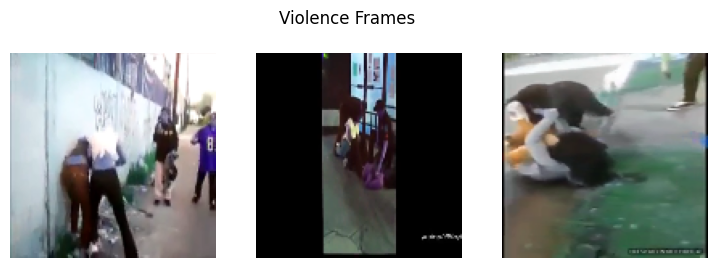

In [15]:
plot_sample_frames(train_violance_frames, "Violence Frames", num_samples=3)

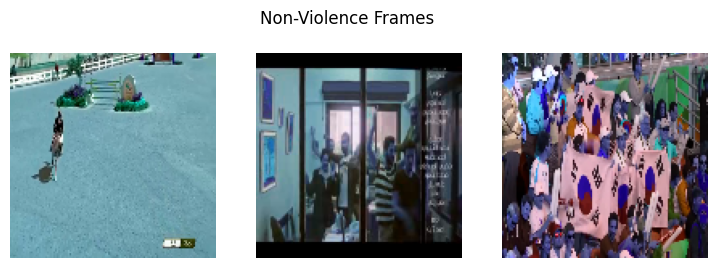

In [16]:
plot_sample_frames(train_non_violance_frames, "Non-Violence Frames", num_samples=3)

In [17]:
!pip install facenet_pytorch

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import torchvision.transforms as T

mtcnn = MTCNN(keep_all=True)
model = InceptionResnetV1(pretrained='vggface2').eval()

def extract_face_embeddings(frames, show_faces=True, max_faces_to_show=15):
    embeddings = []
    shown_faces = 0
    shown_images = []

    for frame in frames:
        faces, probs = mtcnn.detect(frame)

        if faces is not None:
            for i, (x1, y1, x2, y2) in enumerate(faces):
                if x1 < 0 or y1 < 0 or x2 <= x1 or y2 <= y1:
                    continue

                face_crop = frame[int(y1):int(y2), int(x1):int(x2)]

                if face_crop.size == 0:
                    print(f"Skipping empty face crop at {(x1, y1, x2, y2)}")
                    continue

                face_crop_resized = cv2.resize(face_crop, (160, 160))

                face_crop_rgb = cv2.cvtColor(face_crop_resized, cv2.COLOR_BGR2RGB)

                face_tensor = T.ToTensor()(face_crop_rgb).unsqueeze(0)
                with torch.no_grad():
                    embedding = model(face_tensor)

                embeddings.append(embedding[0].cpu().numpy())

                if show_faces and shown_faces < max_faces_to_show:
                    shown_images.append(face_crop_resized)
                    shown_faces += 1

        if shown_faces >= max_faces_to_show:
            break

    if show_faces and shown_images:
        plt.figure(figsize=(15, 5))
        for i, face in enumerate(shown_images):
            plt.subplot(1, max_faces_to_show, i + 1)
            plt.imshow(face)
            plt.axis('off')
        plt.suptitle("Sample Extracted Faces", fontsize=16)
        plt.show()

    return embeddings

  0%|          | 0.00/107M [00:00<?, ?B/s]

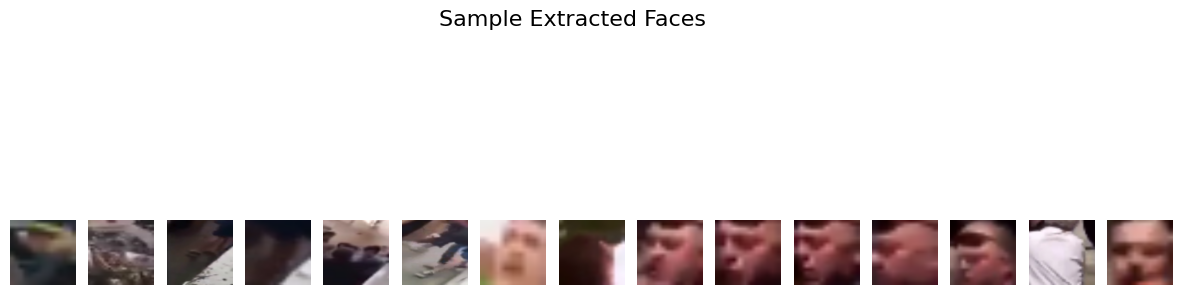

In [19]:
train_violance_face_embeddings = extract_face_embeddings(train_violance_frames, show_faces=True)

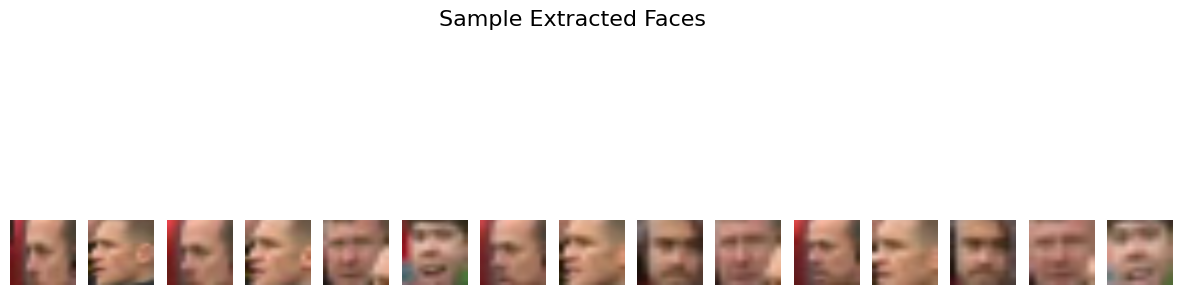

In [20]:
train_non_violance_face_embeddings = extract_face_embeddings(train_non_violance_frames, show_faces=True)

In [21]:
import os
import numpy as np
import moviepy.editor as mp
import librosa
from tqdm import tqdm

  if event.key is 'enter':



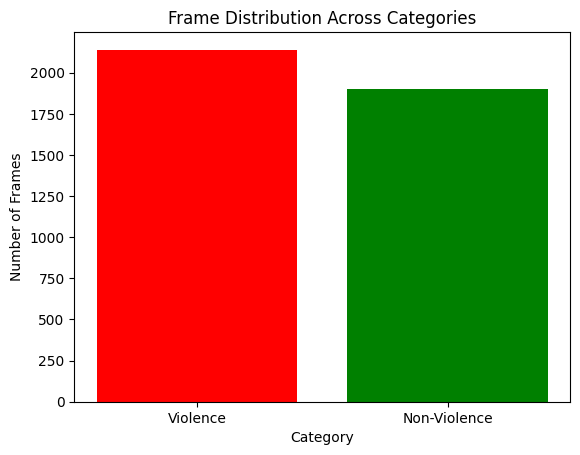

In [36]:
def visualize_frame_distribution(violence_frames, non_violence_frames):
    categories = ['Violence', 'Non-Violence']
    counts = [len(violence_frames), len(non_violence_frames)]
    plt.bar(categories, counts, color=['red', 'green'])
    plt.xlabel("Category")
    plt.ylabel("Number of Frames")
    plt.title("Frame Distribution Across Categories")
    plt.show()

visualize_frame_distribution(train_violance_frames, train_non_violance_frames)

In [22]:
import os
import numpy as np
import moviepy.editor as mp
import librosa
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def extract_audio_embeddings(file_list, dataset_path, n_mfcc=20, max_files=None):
    if max_files is not None:
        file_list = file_list[:max_files]

    embeddings = []
    processed_files = []

    print(f"Extracting audio and creating embeddings for {len(file_list)} videos...")
    for filename in tqdm(file_list):
        try:
            video_path = os.path.join(dataset_path, filename)

            video = mp.VideoFileClip(video_path)
            audio = video.audio

            if audio is None:
                silent_audio = np.zeros(22050)

                mfcc = librosa.feature.mfcc(y=silent_audio, sr=22050, n_mfcc=n_mfcc)
                mfcc_embedding = np.mean(mfcc, axis=1)

                embeddings.append(mfcc_embedding)
                processed_files.append(filename)

                video.close()
                continue

            temp_audio_path = "temp_audio.wav"
            audio.write_audiofile(temp_audio_path, verbose=False, logger=None)

            y, sr = librosa.load(temp_audio_path, sr=None)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            mfcc_embedding = np.mean(mfcc, axis=1)

            embeddings.append(mfcc_embedding)
            processed_files.append(filename)

            os.remove(temp_audio_path)
            video.close()

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    embeddings = np.array(embeddings)

    print(f"Successfully created embeddings for {len(embeddings)} videos")
    print(f"Embedding shape: {embeddings.shape}")

    return embeddings, processed_files


In [23]:
train_audio_violence_embeddings, train_audio_violence_files = extract_audio_embeddings(
    train_violence,
    violence_dataset,
    max_files=100
)

train_audio_non_violence_embeddings, train_audio_non_violence_files = extract_audio_embeddings(
    train_non_violence,
    non_violence_dataset,
    max_files=100
)

np.save("violence_audio_embeddings.npy", train_audio_violence_embeddings)
np.save("violence_filenames.npy", np.array(train_audio_violence_files))

np.save("non_violence_audio_embeddings.npy", train_audio_non_violence_embeddings)
np.save("non_violence_filenames.npy", np.array(train_audio_non_violence_files))



Extracting audio and creating embeddings for 100 videos...


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


Successfully created embeddings for 100 videos
Embedding shape: (100, 20)
Extracting audio and creating embeddings for 100 videos...


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]

Successfully created embeddings for 100 videos
Embedding shape: (100, 20)


In [24]:
train_audio_violence_embeddings = np.array(train_audio_violence_embeddings)
train_violance_face_embeddings = np.array(train_violance_face_embeddings)


train_audio_non_violence_embeddings = np.array(train_audio_non_violence_embeddings)
train_non_violance_face_embeddings = np.array(train_non_violance_face_embeddings)

print(train_audio_non_violence_embeddings.shape)
print(train_non_violance_face_embeddings.shape)

print(train_audio_violence_embeddings.shape)
print(train_violance_face_embeddings.shape)

(100, 20)
(15, 512)
(100, 20)
(15, 512)


In [25]:
import numpy as np

train_violance_face_embeddings_padded = np.pad(train_violance_face_embeddings,
                                               ((0, 100 - train_violance_face_embeddings.shape[0]),
                                                (0, 0)),
                                               mode='constant', constant_values=0)
combined_train_violence_embeddings = np.concatenate([train_audio_violence_embeddings, train_violance_face_embeddings_padded], axis=1)
print(combined_train_violence_embeddings.shape)

(100, 532)


In [26]:
train_non_violance_face_embeddings_padded = np.pad(train_non_violance_face_embeddings,
                                                   ((0, 100 - train_non_violance_face_embeddings.shape[0]),
                                                    (0, 0)),
                                                   mode='constant', constant_values=0)
combined_train_non_violence_embeddings = np.concatenate([train_audio_non_violence_embeddings, train_non_violance_face_embeddings_padded], axis=1)
print(combined_train_non_violence_embeddings.shape)

(100, 532)


In [27]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

violence_labels = torch.ones(train_violance_face_embeddings.shape[0], dtype=torch.long)
non_violence_labels = torch.zeros(train_non_violance_face_embeddings.shape[0], dtype=torch.long)

X = np.concatenate([train_violance_face_embeddings, train_non_violance_face_embeddings], axis=0)
y = np.concatenate([violence_labels, non_violence_labels], axis=0)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [ ]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

violence_labels = torch.ones(combined_train_violence_embeddings.shape[0], dtype=torch.long)
non_violence_labels = torch.zeros(combined_train_non_violence_embeddings.shape[0], dtype=torch.long)

X = np.concatenate([combined_train_violence_embeddings,combined_train_non_violence_embeddings], axis=0)
y = np.concatenate([violence_labels, non_violence_labels], axis=0)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [28]:
violence_labels = np.ones(train_violance_face_embeddings.shape[0])
non_violence_labels = np.zeros(train_non_violance_face_embeddings.shape[0])

X = np.concatenate([train_violance_face_embeddings, train_non_violance_face_embeddings], axis=0)
y = np.concatenate([violence_labels, non_violence_labels], axis=0)

In [29]:
print(X.shape)

(30, 512)


In [30]:
print(len(y))

30


In [33]:
violence_labels = torch.ones(combined_train_violence_embeddings.shape[0], dtype=torch.long)
non_violence_labels = torch.zeros(combined_train_non_violence_embeddings.shape[0], dtype=torch.long)

X = np.concatenate([combined_train_violence_embeddings,combined_train_non_violence_embeddings], axis=0)
y = np.concatenate([violence_labels, non_violence_labels], axis=0)

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import shap

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4899 - loss: 32.4416 - val_accuracy: 0.4750 - val_loss: 6.0759
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4977 - loss: 11.8346 - val_accuracy: 0.4750 - val_loss: 10.1462
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4683 - loss: 14.0654 - val_accuracy: 0.5000 - val_loss: 9.6277
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4999 - loss: 8.7650 - val_accuracy: 0.6250 - val_loss: 8.0318
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5646 - loss: 9.4539 - val_accuracy: 0.6500 - val_loss: 6.0067
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5526 - loss: 7.0735 - val_accuracy: 0.7500 - val_loss: 4.2959
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6247 - loss: 5.7479 - val_accuracy: 0.7250 - val_loss: 3.4408
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5789 - loss: 6.0063 - val_accuracy: 0.7000 - val_loss: 3.0

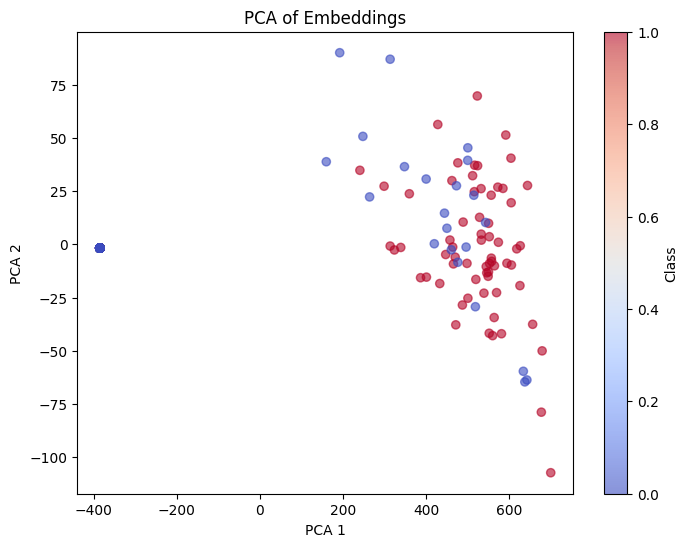

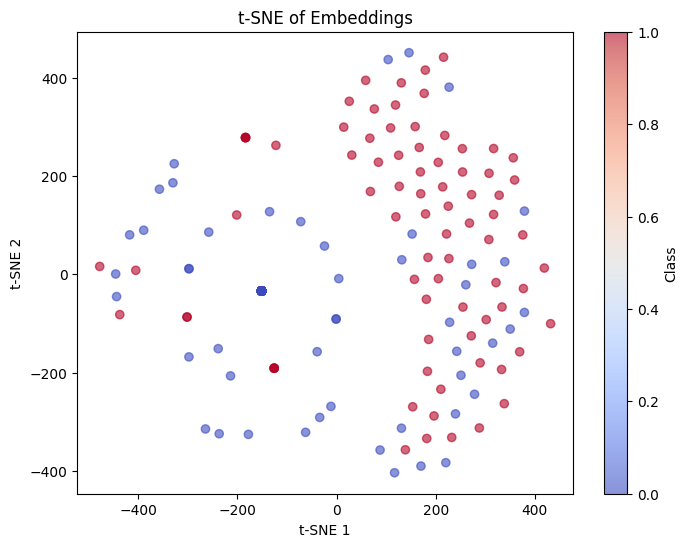

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA of Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Class")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Class")
plt.show()


In [57]:
import shap
import numpy as np

sample_data = X_val[0:1]

background_data = shap.sample(X_train, 100)

explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(sample_data)

shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][0],
    sample_data[0]
)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
9725/9725 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


DimensionError: Length of features is not equal to the length of shap_values!

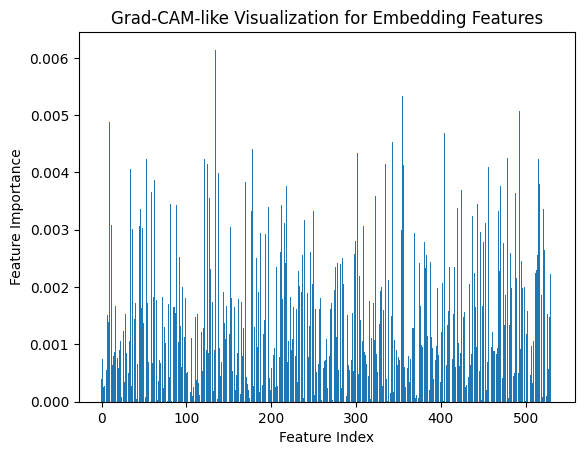

In [59]:
import tensorflow as tf
import numpy as np


def grad_cam_like(model, sample_input):
    sample_input_tensor = tf.convert_to_tensor(sample_input, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_input_tensor)
        prediction = model(sample_input_tensor)

    gradients = tape.gradient(prediction, sample_input_tensor)

    importance = np.abs(gradients.numpy())

    return importance

importance = grad_cam_like(model, X_val[0:1])

plt.bar(range(len(importance[0])), importance[0])
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Grad-CAM-like Visualization for Embedding Features')
plt.show()


In [63]:
pip install --upgrade pdpbox


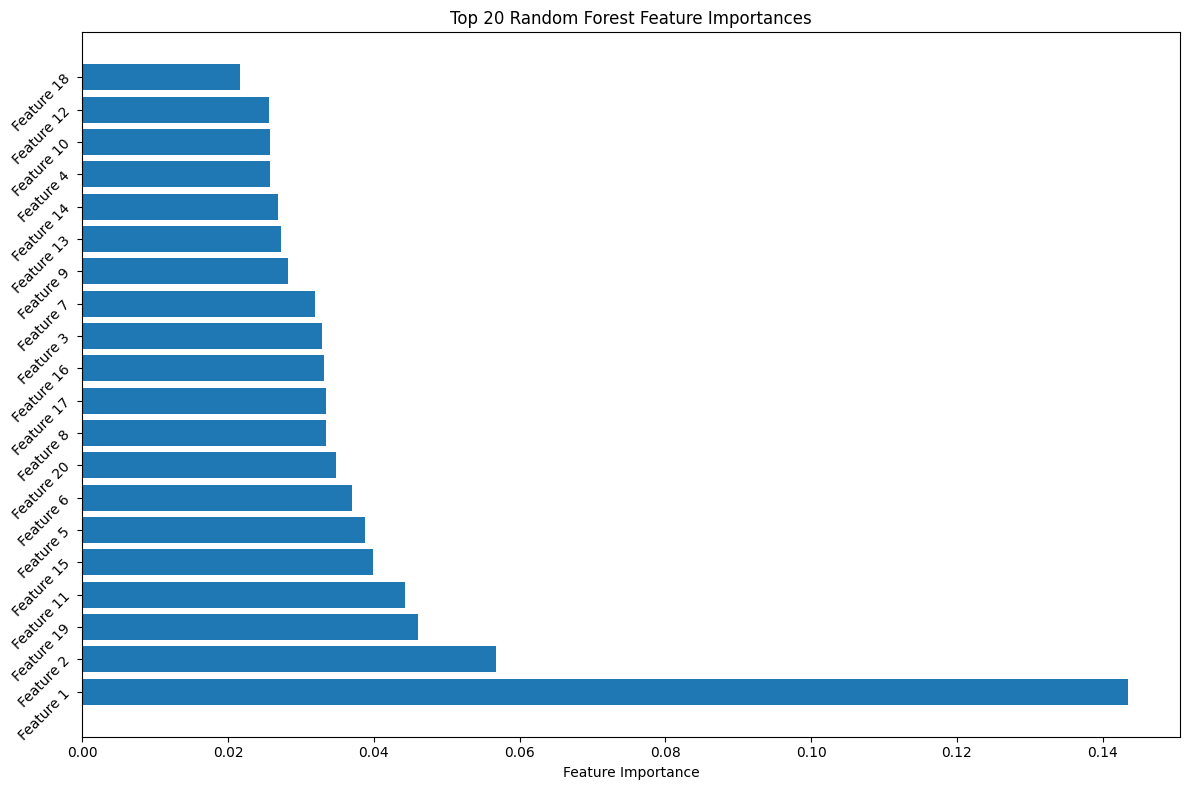

In [73]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_

indices = np.argsort(feature_importances)[::-1]

top_n = 20
indices = indices[:top_n]
top_importances = feature_importances[indices]

plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), [f"Feature {i+1}" for i in indices])

plt.yticks(rotation=45)

plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Random Forest Feature Importances")

plt.tight_layout()

plt.show()
